<a href="https://colab.research.google.com/github/yashsinghkvojhar/yashsinghkvojhar/blob/main/Zee_Recommender_Systems_Case_Study.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

--------------------------------
--------------------------------

# Zee Recommender Systems
--------------------------------
--------------------------------

## Defining Problem Statement & Exploratory Data Analysis

### Problem Statement:

Create a Recommender System to show personalized movie recommendations based on ratings given by a user and other users similar to them in order to improve user experience.

**Concepts Tested:**

•	Recommender Engine

•	Collaborative Filtering (Item-based & User-based Approach)

•	Pearson Correlation

•	Nearest Neighbors using Cosine Similarity

•	Matrix Factorization


### Importing Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style = 'darkgrid')


from sklearn.neighbors import NearestNeighbors

import warnings # supress warnings
warnings.filterwarnings('ignore')

### Importing Data & removing non-relevant columns / duplicates

In [ ]:
raw_movies = pd.read_fwf('zee-movies.dat', encoding='ISO-8859-1')
raw_ratings = pd.read_fwf('zee-ratings.dat', encoding='ISO-8859-1')
raw_users = pd.read_fwf('zee-users.dat', encoding='ISO-8859-1')

In [ ]:
print(f'Shape of Movies data : {raw_movies.shape}')
print(f'Shape of Ratings data : {raw_ratings.shape}')
print(f'Shape of Users data : {raw_users.shape}')

Shape of Movies data : (3883, 3)
Shape of Ratings data : (1000209, 1)
Shape of Users data : (6040, 1)


In [ ]:
print('-'*80)
print(raw_movies.sample(100).head(3))
print('-'*80)
print(raw_ratings.sample(100).head(3))
print('-'*80)
print(raw_users.sample(100).head(3))
print('-'*80)

--------------------------------------------------------------------------------
                              Movie ID::Title::Genres Unnamed: 1 Unnamed: 2
697                    706::Sunset Park (1996)::Drama        NaN        NaN
2429  2498::My Favorite Martian (1999)::Comedy|Sci-Fi        NaN        NaN
3100  3169::Falcon and the Snowman, The (1984)::Drama        NaN        NaN
--------------------------------------------------------------------------------
       UserID::MovieID::Rating::Timestamp
185856           1150::1204::3::975195763
221734           1340::2022::2::974785774
209078            1275::590::3::974807370
--------------------------------------------------------------------------------
     UserID::Gender::Age::Occupation::Zip-code
2702                    2703::M::35::11::52803
265                      266::M::35::11::75229
366                      367::M::50::12::55421
--------------------------------------------------------------------------------


In [ ]:
#creating Clean DataFrame for Movies Data
movies = pd.DataFrame(raw_movies['Movie ID::Title::Genres'].copy(deep = True))
movies['movieID'] = movies['Movie ID::Title::Genres'].apply(lambda x: x.split('::')[0]).astype('int')
movies['title'] = movies['Movie ID::Title::Genres'].apply(lambda x: x.split('::')[1])
movies['genres'] = movies['Movie ID::Title::Genres'].apply(lambda x: x.split('::')[-1])
movies.drop(columns = ['Movie ID::Title::Genres'], inplace = True)
movies.drop_duplicates(keep='last', inplace = True)

In [ ]:
#creating new feature - "Release Year" using regex from title
import re
def get_year(name):
    if len(re.findall(r'\s\((\d{4})\)$', name)) == 1 :
        return re.findall(r'\s\((\d{4})\)$', name)[0]
    else: return '0'

movies['release_year'] = movies['title'].apply(get_year).astype('int')

In [ ]:
#dropping rows where abnormal data is observed
movies = movies.loc[movies['release_year'] != 0]
movies = movies.loc[movies['title'] != movies['genres']]

In [ ]:
#Replacing incomplete words in Genre Columns
movies['genres'].replace({ 'Acti$' : 'Action',
                          'Adv$' : 'Adventure', 'Advent$' : 'Adventure', 'Adventu$' : 'Adventure', 'Adventur$' : 'Adventure',
                          'Animati$' : 'Animation', 'Chi$' : 'Children', 'Chil$' : 'Children', 'Childr$' : 'Children',
                          'Childre$' : 'Children', 'Com$' : 'Comedy', 'Come$' : 'Comedy', 'Comed$' : 'Comedy',
                          'Docu$' : 'Documentary', 'Documen$' : 'Documentary', 'Document$' : 'Documentary',
                          'Documenta$' : 'Documentary', 'Dr$' : 'Drama', 'Dram$' : 'Drama', 'Fant$' : 'Fantasy',
                          'Fantas$' : 'Fantasy', 'Horr$' : 'Horror', 'Horro$' : 'Horror', 'Music$' : 'Musical',
                          'Ro$' : 'Romance', 'Rom$' : 'Romance', 'Roma$' : 'Romance', 'Roman$' : 'Romance', 'Sci$' : 'Sci-Fi',
                          'Sci-$' : 'Sci-Fi', 'Sci-F$' : 'Sci-Fi', 'Thri$' : 'Thriller', 'Thrille$' : 'Thriller', 'Wa$' : 'War',
                          'We$' : 'Western', 'Wester$' : 'Western'}, regex=True, inplace = True)
movies['genres'].replace({"Children's" : "Children", "Children'": "Children", "Sci-Fi" : "SciFi",
                          "Film-Noir": "FilmNoir" }, regex=True, inplace = True)
movies['genres'] = movies['genres'].str.lower()


In [ ]:
print('-'*80)
print(f'Shape of Movies data : {movies.shape}')
print('-'*80)
movies.sample(100).head()

--------------------------------------------------------------------------------
Shape of Movies data : (3857, 4)
--------------------------------------------------------------------------------


,movieID,title,genres,release_year
3397,3466,Heart and Souls (1993),comedy|fantasy,1993
1339,1360,Identification of a Woman (Identificazione di ...,,1982
2210,2279,Urban Legend (1998),horror|thriller,1998
3856,3926,Voyage to the Bottom of the Sea (1961),adventure|scifi,1961
1963,2032,"Barefoot Executive, The (1971)",children|comedy,1971


In [ ]:
#creating Clean DataFrame for Ratings Data
ratings = pd.DataFrame(raw_ratings['UserID::MovieID::Rating::Timestamp'].copy(deep = True))
ratings['userID'] = ratings['UserID::MovieID::Rating::Timestamp'].apply(lambda x: x.split('::')[0]).astype('int')
ratings['movieID'] = ratings['UserID::MovieID::Rating::Timestamp'].apply(lambda x: x.split('::')[1]).astype('int')
ratings['rating'] = ratings['UserID::MovieID::Rating::Timestamp'].apply(lambda x: x.split('::')[2]).astype('int')
ratings['timestamp'] = ratings['UserID::MovieID::Rating::Timestamp'].apply(lambda x: x.split('::')[-1])
ratings.drop(columns = ['UserID::MovieID::Rating::Timestamp'], inplace = True)
ratings.drop_duplicates(keep='last', inplace = True)

In [ ]:
#creating new column to convert timestamp to datetime format
ratings['timestamp'] = pd.to_datetime(ratings['timestamp'], unit='s')

In [ ]:
print('-'*80)
print(f'Shape of Ratings data : {ratings.shape}')
print('-'*80)
ratings.sample(100).head()

--------------------------------------------------------------------------------
Shape of Ratings data : (1000209, 4)
--------------------------------------------------------------------------------


,userID,movieID,rating,timestamp
610869,3705,934,5,2000-08-14 19:56:23
484364,2980,3578,3,2001-02-24 22:04:14
638193,3841,2150,4,2000-08-11 12:24:28
641954,3859,76,3,2000-08-10 17:15:49
248415,1499,1707,4,2000-11-21 23:42:41


In [ ]:
#creating Clean DataFrame for Users Data
users = pd.DataFrame(raw_users['UserID::Gender::Age::Occupation::Zip-code'].copy(deep = True))
users['userID'] = users['UserID::Gender::Age::Occupation::Zip-code'].apply(lambda x: x.split('::')[0]).astype('int')
users['gender'] = users['UserID::Gender::Age::Occupation::Zip-code'].apply(lambda x: x.split('::')[1])
users['age'] = users['UserID::Gender::Age::Occupation::Zip-code'].apply(lambda x: x.split('::')[2]).astype('int')
users['occupation'] = users['UserID::Gender::Age::Occupation::Zip-code'].apply(lambda x: x.split('::')[3]).astype('int')
users['zip_code'] = users['UserID::Gender::Age::Occupation::Zip-code'].apply(lambda x: x.split('::')[-1])
users.drop(columns = ['UserID::Gender::Age::Occupation::Zip-code'], inplace = True)
users.drop_duplicates(keep='last', inplace = True)

In [ ]:
#convert Gender column to 0: female & 1 : male
users['gender'] = users['gender'].map({'F': 0, 'M': 1}).astype('int')

In [ ]:
print('-'*80)
print(f'Shape of Users data : {users.shape}')
print('-'*80)
users.sample(100).head()

--------------------------------------------------------------------------------
Shape of Users data : (6040, 5)
--------------------------------------------------------------------------------


,userID,gender,age,occupation,zip_code
5132,5133,1,18,11,10028
919,920,1,18,4,92173
1804,1805,1,18,4,22401
4089,4090,1,56,6,77379
2425,2426,1,56,0,01606


In [ ]:
#Creating csv to analysis
movies.to_csv('movies.csv')
ratings.to_csv('ratings.csv')
users.to_csv('users.csv')

### Exploratory Data Analysis

**Movie count by release year**

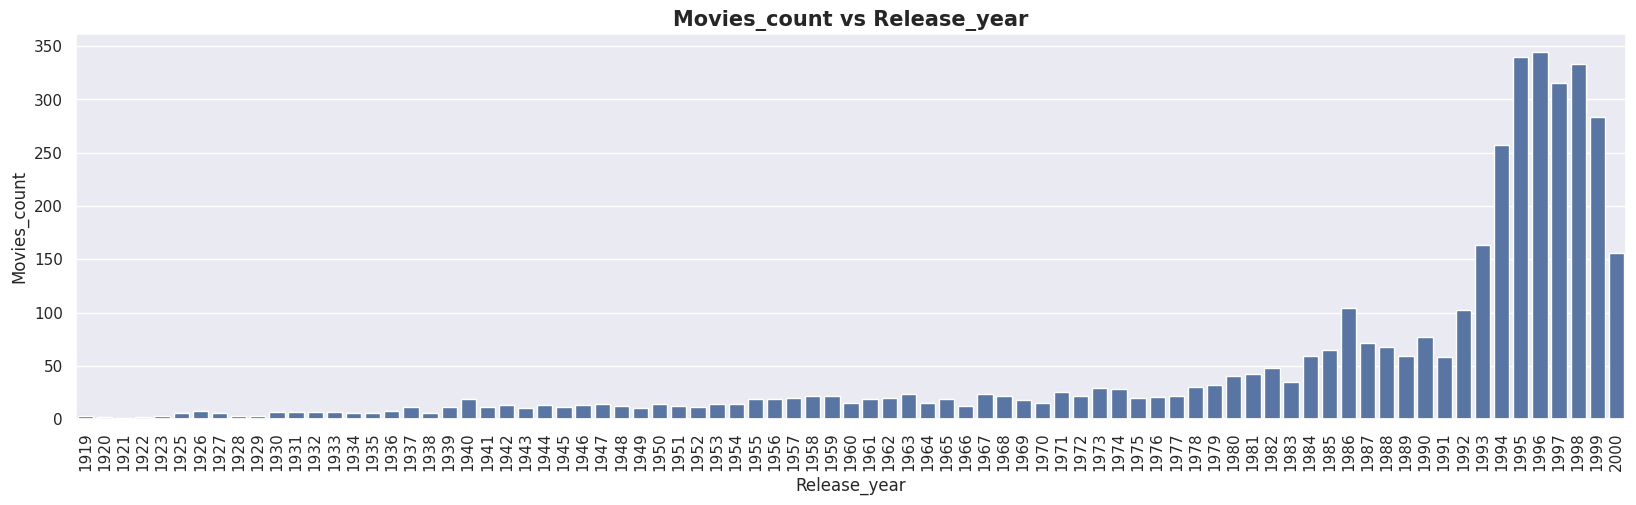

In [ ]:
plt.figure(figsize=(20,5))
x = movies['release_year'].value_counts().index
y = movies['release_year'].value_counts().values
sns.barplot(x=x, y=y)
plt.xticks(rotation=90)
plt.xlabel('Release_year')
plt.ylabel('Movies_count')
plt.title('Movies_count vs Release_year', fontsize = 15, fontweight = 'bold')
plt.show()

**Movie Count by Genre**

In [ ]:
movie_genre = movies[['title', 'genres']].copy(deep = True)
movie_genre = movie_genre.assign(genres  = movie_genre['genres'].str.split('|')).explode('genres')
movie_genre.genres = movie_genre.genres.str.strip()

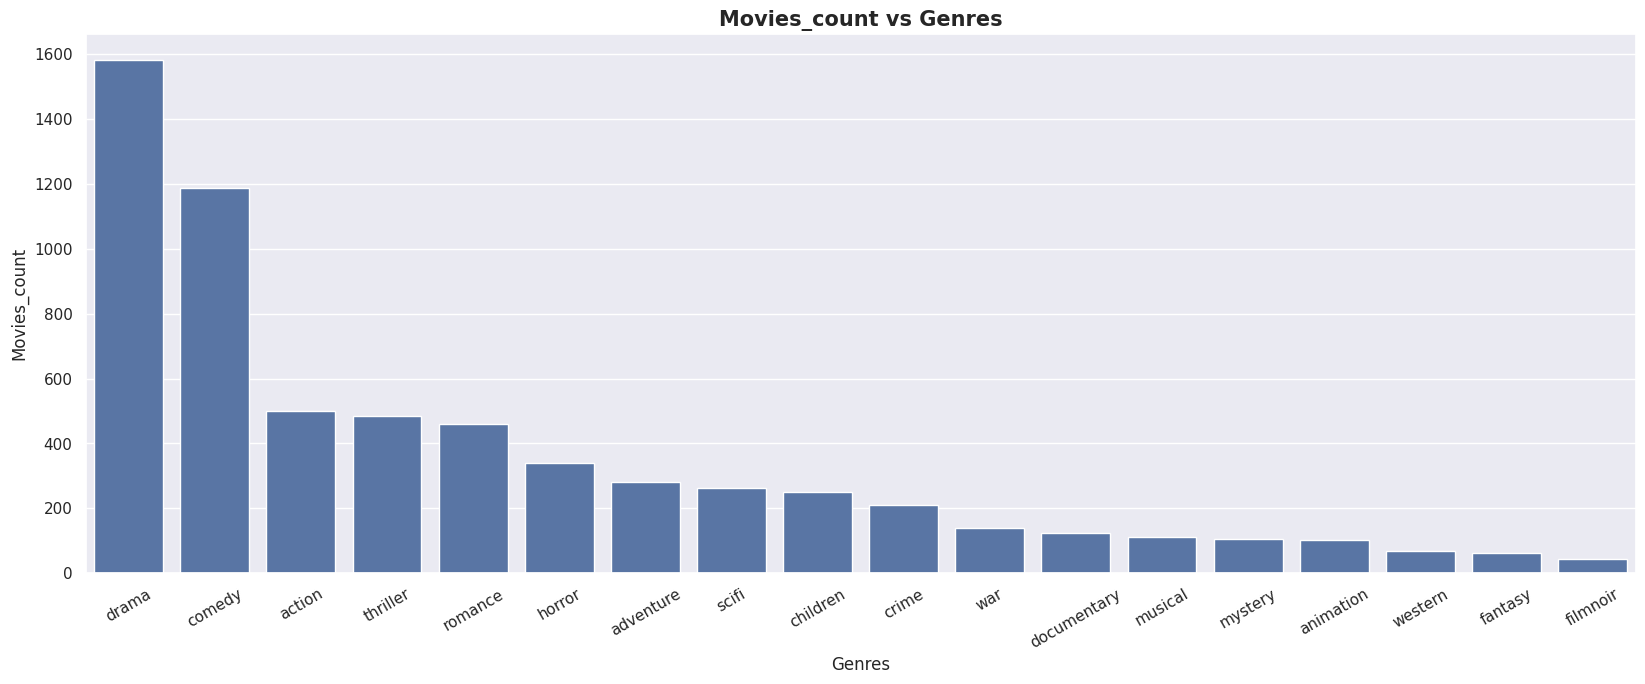

In [ ]:
plt.figure(figsize=(20,7))
x = movie_genre.genres.value_counts().index
y = movie_genre.genres.value_counts().values
sns.barplot(x=x[:18], y=y[:18])
plt.xticks(rotation=30)
plt.xlabel('Genres')
plt.ylabel('Movies_count')
plt.title('Movies_count vs Genres', fontsize = 15, fontweight = 'bold')
plt.show()

**Users Gender, Age & Occupation distribution**

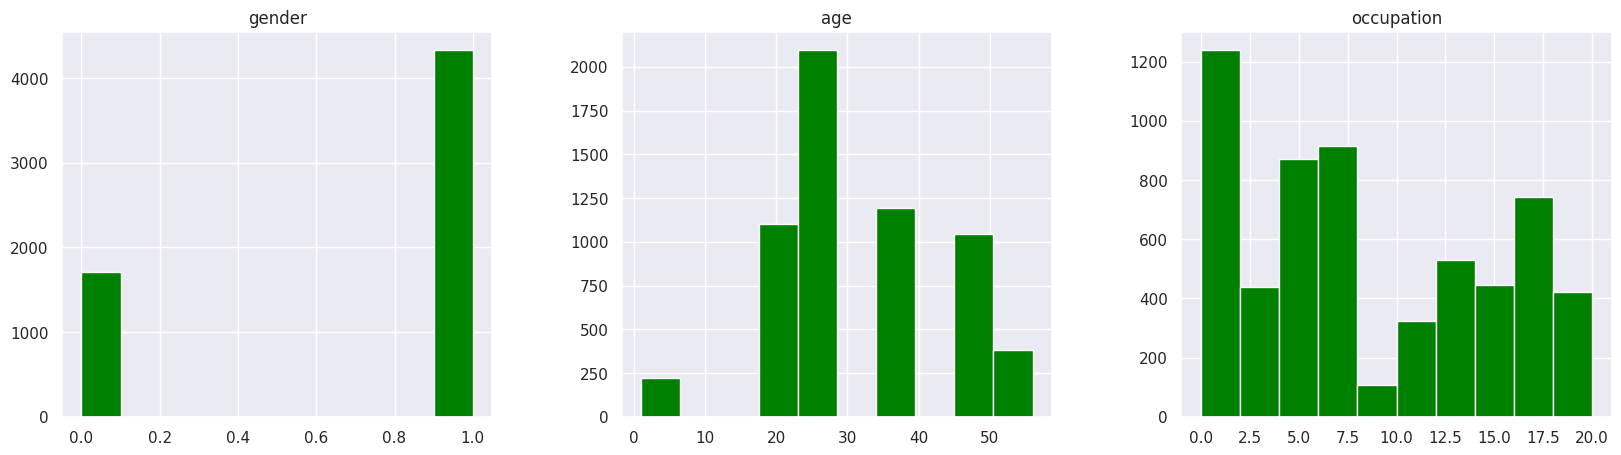

In [ ]:
users[['gender','age', 'occupation']].hist(figsize=(20,5), layout=(1,3), color ='green')
plt.show()

### Merging the data files and creating a single consolidated dataframe

In [ ]:
#merging all three dataframes to single DataFrame : data
data = ratings.merge(movies, how = 'inner', on = 'movieID')
data = data.merge(users, how = 'inner', on = 'userID')

In [ ]:
data.to_csv('data.csv')

In [ ]:
print('-'*80)
print(f'Shape of Combined data : {data.shape}')
print('-'*80)
data.sample(100).head()

--------------------------------------------------------------------------------
Shape of Combined data : (996144, 11)
--------------------------------------------------------------------------------


,userID,movieID,rating,timestamp,title,genres,release_year,gender,age,occupation,zip_code
944684,5728,1958,3,2000-05-16 09:47:35,Terms of Endearment (1983),comedy|drama,1983,0,35,20,09824
447638,2771,1376,4,2000-11-15 01:45:33,Star Trek IV: The Voyage Home (1986),action|adventure|scifi,1986,1,18,1,92037
322767,1920,48,3,2000-11-21 03:39:14,Pocahontas (1995),animation|children|musical|romance,1995,0,35,7,80122
459501,2846,2710,4,2000-10-26 02:20:23,"Blair Witch Project, The (1999)",horror,1999,0,18,4,91604
617497,3756,277,3,2000-08-12 17:01:05,Miracle on 34th Street (1994),drama,1994,1,18,12,53188


In [ ]:
data.describe(include= np.number).round(2).T

,count,mean,std,min,25%,50%,75%,max
userID,996144.0,3024.00,1728.27,1.0,1505.0,3069.0,4476.0,6040.0
movieID,996144.0,1867.03,1096.03,1.0,1032.0,1836.0,2770.0,3952.0
rating,996144.0,3.58,1.12,1.0,3.0,4.0,4.0,5.0
release_year,996144.0,1986.76,14.31,1919.0,1982.0,1992.0,1997.0,2000.0
gender,996144.0,0.75,0.43,0.0,1.0,1.0,1.0,1.0
age,996144.0,29.73,11.75,1.0,25.0,25.0,35.0,56.0
occupation,996144.0,8.03,6.53,0.0,2.0,7.0,14.0,20.0


In [ ]:
data.describe(include= 'object').round(2).T

,count,unique,top,freq
title,996144,3682,American Beauty (1999),3428
genres,996144,308,comedy,116779
zip_code,996144,3439,94110,3782


### Creating Movie Recommender using various models

![image.png](attachment:image.png)

**Group the data according to the average rating and no. of ratings**

In [ ]:
data_pivot_rating = pd.pivot_table(data, index = 'title', values='rating', aggfunc = ['count', 'mean']).round(5)
data_pivot_rating.columns = ['_'.join(col).strip() for col in data_pivot_rating.columns.values]
data_pivot_rating.sort_values(by =['count_rating', 'mean_rating'], ascending=False, inplace = True)

In [ ]:
##Top 10 Most rated Movies & their average Rating
data_pivot_rating.head(10)

,count_rating,mean_rating
title,,
American Beauty (1999),3428,4.31739
Star Wars: Episode IV - A New Hope (1977),2991,4.45369
Star Wars: Episode V - The Empire Strikes Back (1980),2990,4.29298
Star Wars: Episode VI - Return of the Jedi (1983),2883,4.02289
Jurassic Park (1993),2672,3.76385
Saving Private Ryan (1998),2653,4.33735
Terminator 2: Judgment Day (1991),2649,4.05851
"Matrix, The (1999)",2590,4.31583
Back to the Future (1985),2583,3.99032


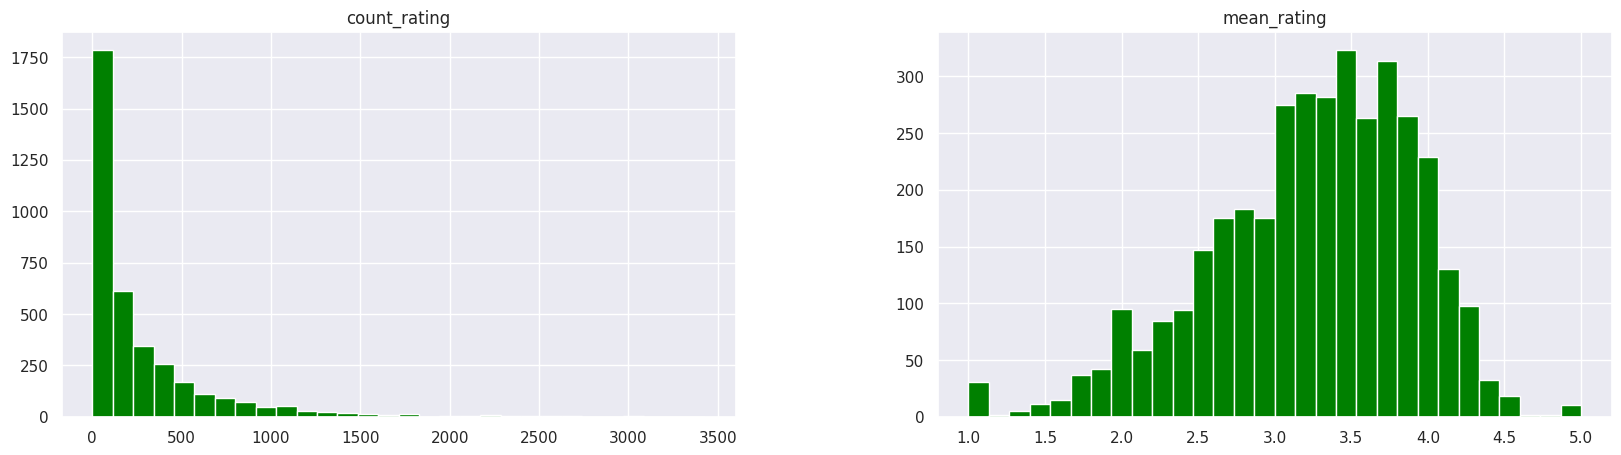

In [ ]:
data_pivot_rating.hist(figsize=(20,5), bins=30, layout=(1,2), color ='green')
plt.show()

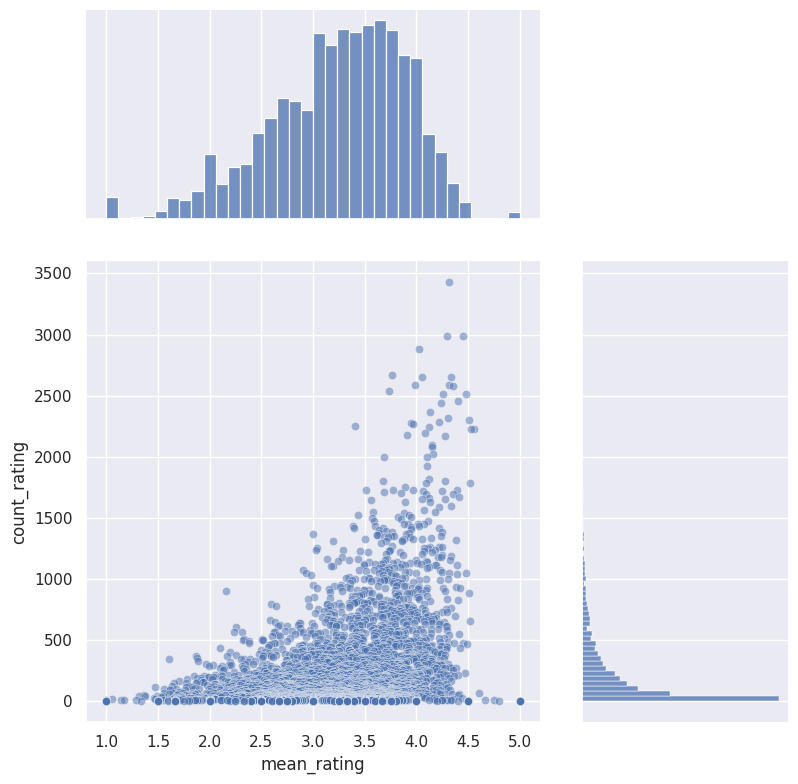

In [ ]:
sns.jointplot(x='mean_rating',y='count_rating',data=data_pivot_rating,alpha=0.5, height=8, ratio =2)
plt.show()

**Creating a pivot table of movie titles & user id and imputing the NaN values**

In [ ]:
movie_matrix = pd.pivot_table(data, index = 'userID', columns = 'title', values='rating', fill_value=0)

In [ ]:
print('-'*80)
print(f'Shape of Movie Matrix : {movie_matrix.shape}')
print('-'*80)
movie_matrix.sample(100).head()

--------------------------------------------------------------------------------
Shape of Movie Matrix : (6040, 3682)
--------------------------------------------------------------------------------


title,"$1,000,000 Duck (1971)",'Night Mother (1986),'Til There Was You (1997),"'burbs, The (1989)",...And Justice for All (1979),1-900 (1994),10 Things I Hate About You (1999),101 Dalmatians (1961),101 Dalmatians (1996),12 Angry Men (1957),...,"Young Poisoner's Handbook, The (1995)",Young Sherlock Holmes (1985),Young and Innocent (1937),Your Friends and Neighbors (1998),Zachariah (1971),"Zed & Two Noughts, A (1985)",Zero Effect (1998),Zero Kelvin (Kjærlighetens kjøtere) (1995),Zeus and Roxanne (1997),eXistenZ (1999)
userID,,,,,,,,,,,,,,,,,,,,,
2692,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
447,0.0,5.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2689,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3275,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4888,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,...,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Movie - Movie Similarity Matrix (Correlation between Movies)

In [ ]:
#Creating Similarity Matrix for 20 Top Rated Movies
n = 20
sample_movies = data_pivot_rating.head(n).index
movie_matrix_sample = movie_matrix.loc[:,movie_matrix.columns.isin(sample_movies)]

--------------------------------------------------------------------------------
Shape of Movie-Movie Similarity Matrix : (20, 20)
--------------------------------------------------------------------------------


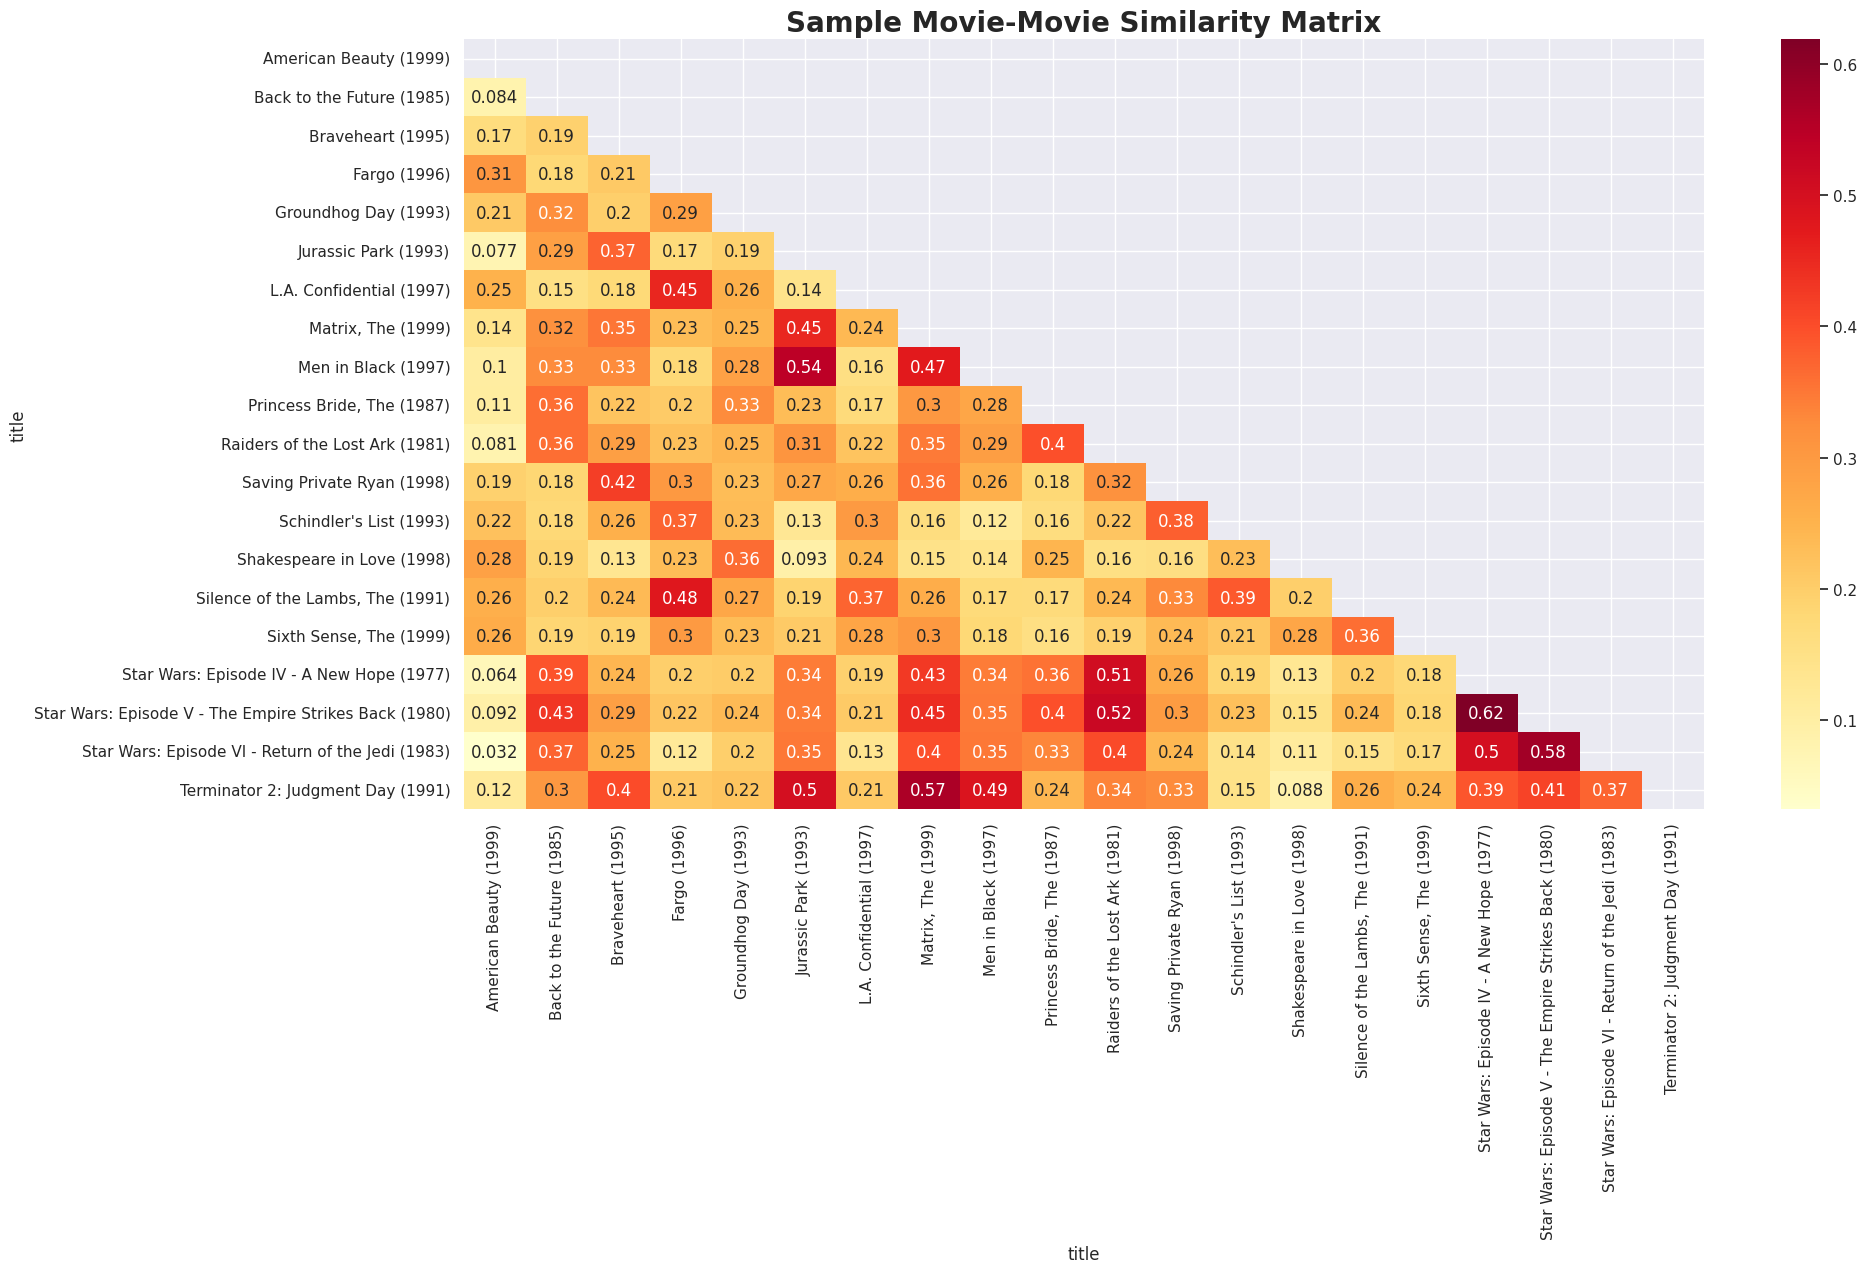

In [ ]:
print('-'*80)
print(f'Shape of Movie-Movie Similarity Matrix : {movie_matrix_sample.corr().shape}')
print('-'*80)
plt.figure(figsize=(20,10))
mask = np.triu(movie_matrix_sample.corr())
plt.title('Sample Movie-Movie Similarity Matrix', fontsize = 20, fontweight = 'bold')
sns.heatmap(movie_matrix_sample.corr(), annot = True, cmap = 'YlOrRd',  mask = mask)
plt.show()

### User - User Similarity Matrix (Correlation between Users)

In [ ]:
#Creating Similarity Matrix random 20 Users
m = 20
sample_users = users.userID.sample(m)
sample_users = sample_users.values
user_matrix_sample = movie_matrix.loc[movie_matrix.index.isin(sample_users)]
user_matrix_sample = user_matrix_sample.T

--------------------------------------------------------------------------------
Shape of User-User Similarity Matrix : (20, 20)
--------------------------------------------------------------------------------


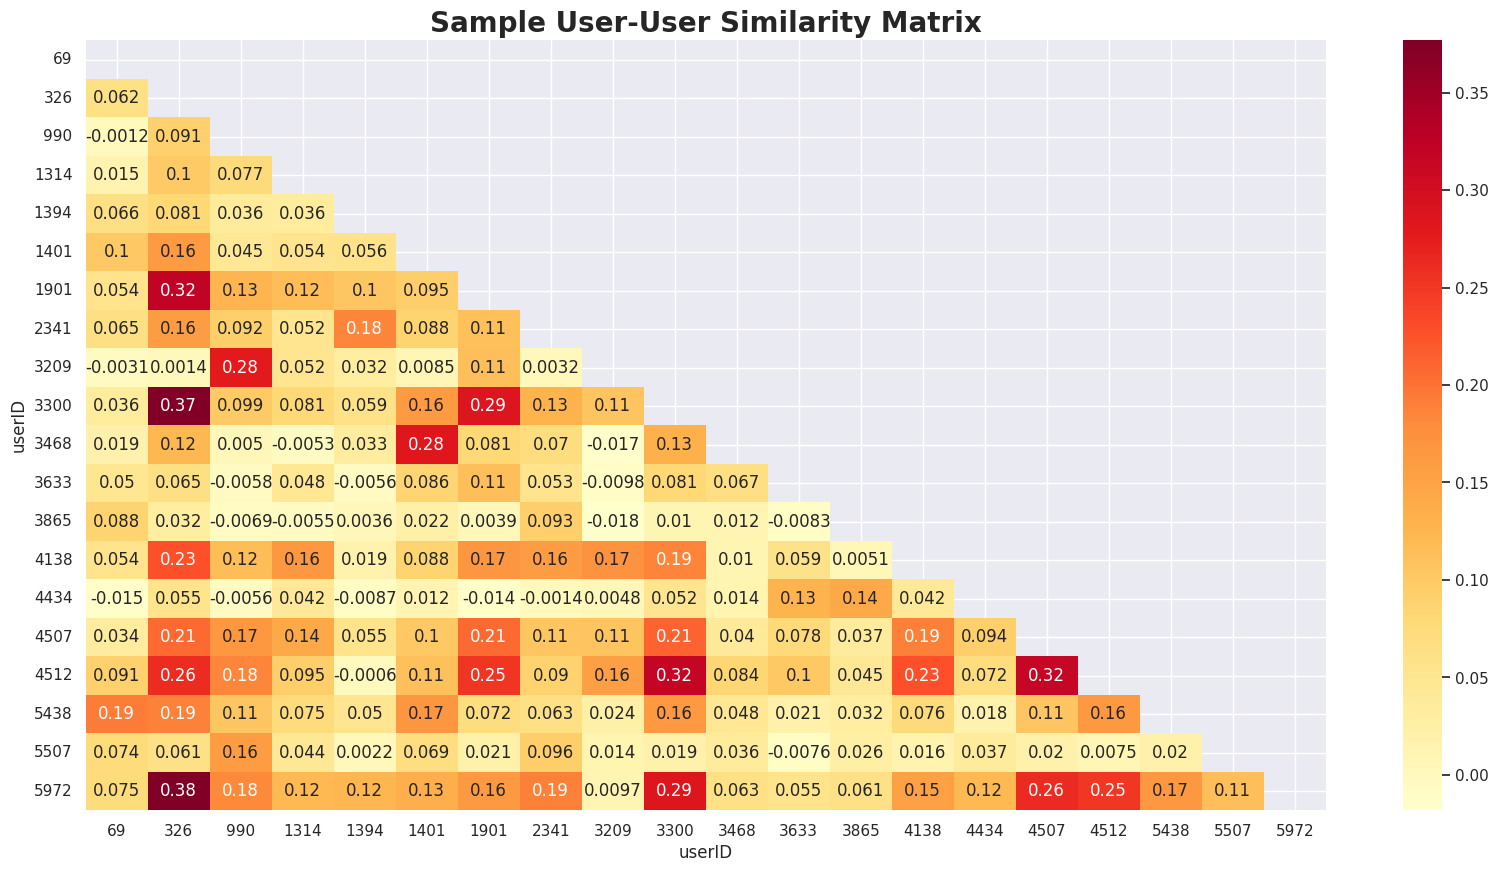

In [ ]:
print('-'*80)
print(f'Shape of User-User Similarity Matrix : {user_matrix_sample.corr().shape}')
print('-'*80)
plt.figure(figsize=(20,10))
plt.title('Sample User-User Similarity Matrix', fontsize = 20, fontweight = 'bold')
mask = np.triu(user_matrix_sample.corr())
sns.heatmap(user_matrix_sample.corr(), annot = True, mask = mask, cmap = 'YlOrRd')
plt.yticks(rotation=0)
plt.show()

### Model 1: Recommender System based on Pearson Correlation

In [ ]:
#Creating function for Movie Recommender system

def recommender_1(movie, movie_matrix, data_pivot_rating, n_reccomend = 5):
    movie_rating = movie_matrix[movie]
    similar_movies = movie_matrix.corrwith(movie_rating)
    corr_movie = pd.DataFrame(similar_movies,columns=['Correlation'])
    corr_movie.dropna(inplace=True)
    corr_movie = corr_movie.join(data_pivot_rating['count_rating'])
    recommended_movies = corr_movie[corr_movie['count_rating']>100].sort_values('Correlation',ascending=False).head(n_reccomend+1)
    print('-'*100)
    print(f'Top {n_reccomend} Recommended Movies to "{movie}" are as follow:')
    print('-'*100)
    for mov in recommended_movies.index:
        if mov != movie : print(mov)
    print('-'*100)
    return None

In [ ]:
#Testing for 1 Movie
movie = 'Shawshank Redemption, The (1994)'
recommender_1(movie, movie_matrix, data_pivot_rating, n_reccomend = 10)

----------------------------------------------------------------------------------------------------
Top 10 Recommended Movies to "Shawshank Redemption, The (1994)" are as follow:
----------------------------------------------------------------------------------------------------
Silence of the Lambs, The (1991)
Good Will Hunting (1997)
Pulp Fiction (1994)
Schindler's List (1993)
Fargo (1996)
GoodFellas (1990)
Usual Suspects, The (1995)
Sling Blade (1996)
Jerry Maguire (1996)
Few Good Men, A (1992)
----------------------------------------------------------------------------------------------------


In [ ]:
#Results for top 5 most rated Movies in dataset
test_movies = data_pivot_rating.head(5).index
for mov in test_movies:
    recommender_1(mov, movie_matrix, data_pivot_rating, n_reccomend = 5)

----------------------------------------------------------------------------------------------------
Top 5 Recommended Movies to "American Beauty (1999)" are as follow:
----------------------------------------------------------------------------------------------------
Being John Malkovich (1999)
Election (1999)
Pulp Fiction (1994)
Fight Club (1999)
Clerks (1994)
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Top 5 Recommended Movies to "Star Wars: Episode IV - A New Hope (1977)" are as follow:
----------------------------------------------------------------------------------------------------
Star Wars: Episode V - The Empire Strikes Back (1980)
Raiders of the Lost Ark (1981)
Star Wars: Episode VI - Return of the Jedi (1983)
Terminator, The (1984)
Alien (1979)
-------------------------------------------------------------------------

### Model 2: Recommender System based on Cosine Similarity, KNearestNeighbours

In [ ]:
def recommender_2(movie, movie_matrix, n_reccomend = 5):
    nn_recomender = NearestNeighbors(metric='cosine')
    nn_recomender.fit(movie_matrix.T)
    distance,neighbors = nn_recomender.kneighbors([movie_matrix.loc[:,movie]],n_neighbors=n_reccomend+1)
    recommended_movies = [movie_matrix.T.iloc[i].name for i in neighbors[0]]
    print('-'*100)
    print(f'Top {n_reccomend} Recommended Movies to "{movie}" are as follow:')
    print('-'*100)
    for mov in recommended_movies:
        if mov != movie : print(mov)
    print('-'*100)
    return None

In [ ]:
#Testing for 1 Movie
movie = 'Shawshank Redemption, The (1994)'
recommender_2(movie, movie_matrix, n_reccomend = 10)

----------------------------------------------------------------------------------------------------
Top 10 Recommended Movies to "Shawshank Redemption, The (1994)" are as follow:
----------------------------------------------------------------------------------------------------
Silence of the Lambs, The (1991)
Pulp Fiction (1994)
Fargo (1996)
Schindler's List (1993)
Good Will Hunting (1997)
Saving Private Ryan (1998)
GoodFellas (1990)
American Beauty (1999)
Usual Suspects, The (1995)
Groundhog Day (1993)
----------------------------------------------------------------------------------------------------


In [ ]:
#Results for top 5 most rated Movies in dataset
test_movies = data_pivot_rating.head(5).index
for mov in test_movies:
    recommender_2(mov, movie_matrix, n_reccomend = 5)

----------------------------------------------------------------------------------------------------
Top 5 Recommended Movies to "American Beauty (1999)" are as follow:
----------------------------------------------------------------------------------------------------
Being John Malkovich (1999)
Fargo (1996)
Pulp Fiction (1994)
Silence of the Lambs, The (1991)
Shakespeare in Love (1998)
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Top 5 Recommended Movies to "Star Wars: Episode IV - A New Hope (1977)" are as follow:
----------------------------------------------------------------------------------------------------
Star Wars: Episode V - The Empire Strikes Back (1980)
Star Wars: Episode VI - Return of the Jedi (1983)
Raiders of the Lost Ark (1981)
Terminator, The (1984)
Alien (1979)
------------------------------------------------

### Model 3 : Recommender System based on Matrix Factorization  (Using Surprise Package)

In [ ]:
!pip install scikit-surprise

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.4/154.4 kB 3.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.4-cp310-cp310-linux_x86_64.whl size=2357278 sha256=abf68392a562cd7e877fcb73c603ed1c40b86c854aa7ab4af38527204290b2ef
  Stored in directory: /root/.cache/pip/wheels/4b/3f/df/6acbf0a40397d9bf3ff97f582cc22fb9ce66adde75bc71fd54
Successfully built scikit-surprise


In [ ]:
from surprise import Reader, Dataset, SVD
from surprise.model_selection import cross_validate

**Evaluate the model in terms of the Root Mean Squared Error and Mean Absolute Percentage Error**

In [ ]:
d = 4
reader = Reader(rating_scale = (1, 5))
svd = SVD(random_state=23, n_factors=d, n_epochs=10, verbose=True)

data_svd = Dataset.load_from_df(data[['userID', 'movieID', 'rating']], reader)
results = cross_validate(svd, data_svd, measures=['RMSE', 'MAE'], cv=3, verbose=True)

Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Evaluating RMSE, MAE of algorithm SVD on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.9129  0.9088  0.9090  0.9102  0.0019  
MAE (testset)     0.7230  0.7201  0.7203  0.7211  0.0013  
Fit time          4.22    4.38    3.74    4.11    0.27    
Test time         4.07    4.03    4.94    4.35    0.42    


-------------------
**Model Performance 3 Folds CV:**
- Mean RMSE = 0.9100 and
- Mean MAE = 0.7209

**Average Time taken to Fit Model : 7.25 and to Test model = 3.10**

---------------------------

In [ ]:
!pip install recommenders

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.4/316.4 kB 8.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.1/44.1 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 356.0/356.0 kB 15.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.0/82.0 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 65.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 42.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 93.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 259.6/259.6 kB 16.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 69.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.7/112.7 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.9/468.9 kB 25.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.6/383.6 kB 23.3 MB/s eta 0:00:00
   ━━

In [ ]:
#splitting our data into trainset and testset
from recommenders.datasets.python_splitters import python_random_split
train, test = python_random_split(data[['userID', 'movieID', 'rating']], 0.75)

In [ ]:
print(train.shape)
print(test.shape)

(747108, 3)
(249036, 3)


In [ ]:
test.head(3)

,userID,movieID,rating
575967,3532,1701,2
872991,5293,608,4
466994,2888,2424,1


In [ ]:

#'reader' is being used to get rating scale (for data, the scale is [1, 5]).
reader = Reader(rating_scale = (1, 5))

#Surprise needs to build an internal model of the data. We here use the load_from_df method to build a Dataset object
train_set = Dataset.load_from_df(train, reader=reader).build_full_trainset()
train_set

In [ ]:
#Fitting the Model using SVD algorithm

from recommenders.utils.timer import Timer
svd1 = SVD(random_state=23, n_factors=4, n_epochs=10, verbose=True)

with Timer() as train_time:
    svd1.fit(train_set)

print("Took {} seconds for training.".format(train_time.interval))

Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Took 4.751467739999953 seconds for training.


In [ ]:
#Creating predictions after fitting the model

from recommenders.models.surprise.surprise_utils import predict
predictions = predict(svd1, test, usercol='userID', itemcol='movieID')
predictions.head()

,userID,movieID,prediction
0,3532,1701,3.721704
1,5293,608,4.080484
2,2888,2424,3.419244
3,1489,2550,2.444016
4,5493,1399,3.047185


In [ ]:
#Merging the Predictions with Actual Ratings and plotting to visualize the results
check_predictions = test.merge(predictions, how='left', left_on=['userID','movieID'], right_on = ['userID','movieID'])

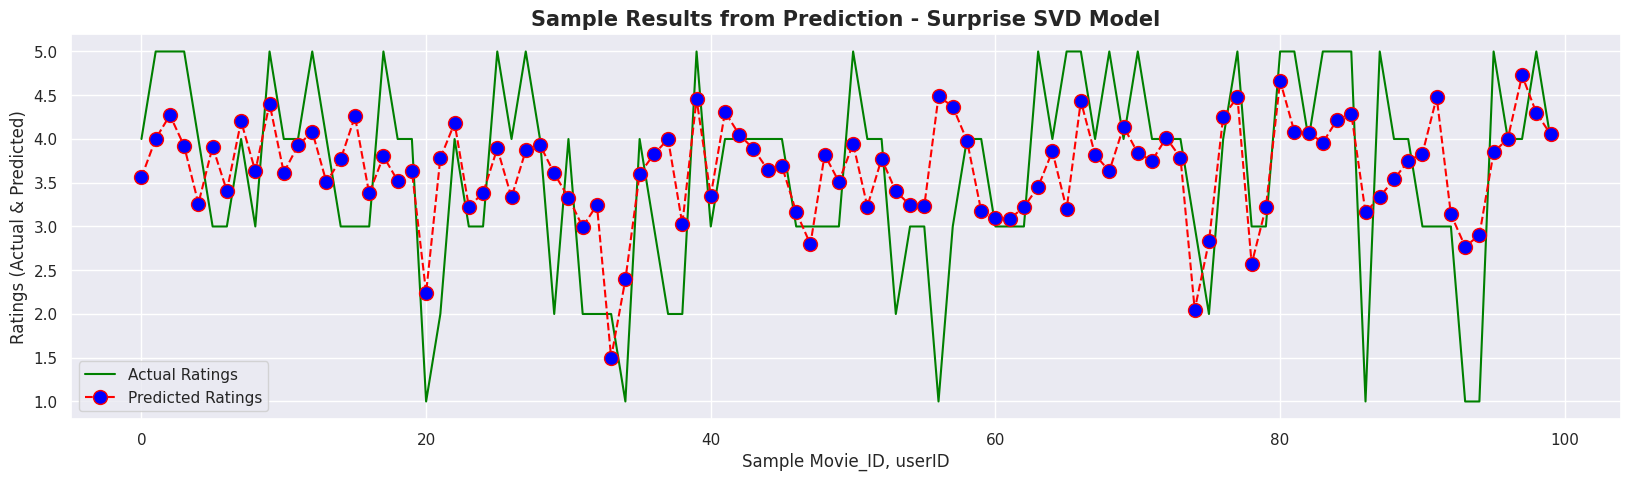

In [ ]:
plt.figure(figsize=(20,5))
d = 100
x = range(d)
initial_pointer = np.random.randint(100)
final_pointer = initial_pointer+d

y1 = check_predictions.loc[range(initial_pointer,final_pointer),'rating']
y2 = check_predictions.loc[range(initial_pointer,final_pointer),'prediction']

plt.plot(x, y1, label = 'Actual Ratings', color='green')
plt.plot(x, y2, label = 'Predicted Ratings', color='red', linestyle='dashed', marker='o',markerfacecolor='blue', markersize=10)

plt.ylabel('Ratings (Actual & Predicted)')
plt.xlabel('Sample Movie_ID, userID')
plt.title('Sample Results from Prediction - Surprise SVD Model', fontsize = 15, fontweight = 'bold')
plt.legend()
plt.show()

### Questionnaire

**1.	Users of which age group have watched and rated the most number of movies?**

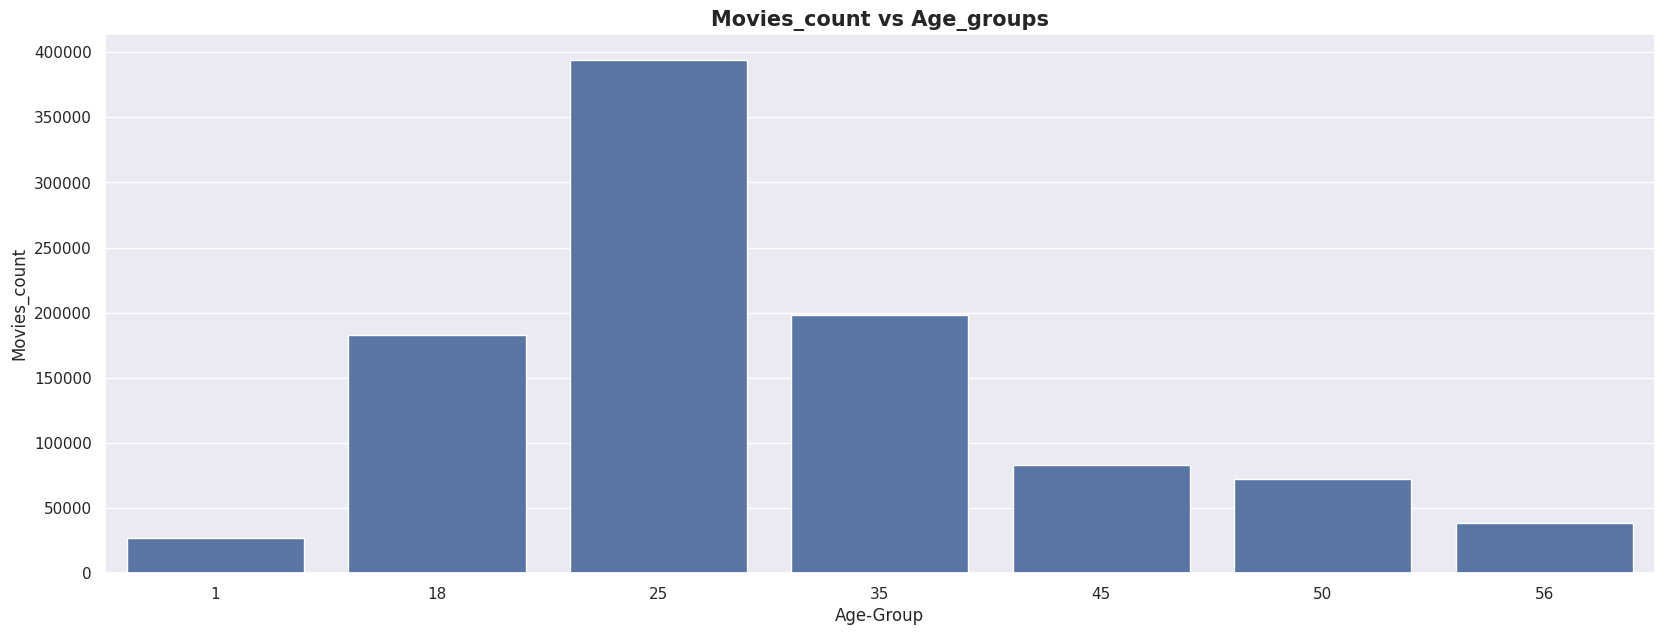

In [ ]:
plt.figure(figsize=(20,7))
x = data.age.value_counts().sort_index().index
y = data.age.value_counts().sort_index().values
sns.barplot(x=x, y=y)
plt.xlabel('Age-Group')
plt.ylabel('Movies_count')
plt.title('Movies_count vs Age_groups', fontsize = 15, fontweight = 'bold')
plt.show()


=> Users of age group **25: "25-34"** have watched and rated most number of movies followed by **35: "35-44"** and **18: "18-24"**.

--------------------------------

**2.	Users belonging to which profession have watched and rated the most movies?**

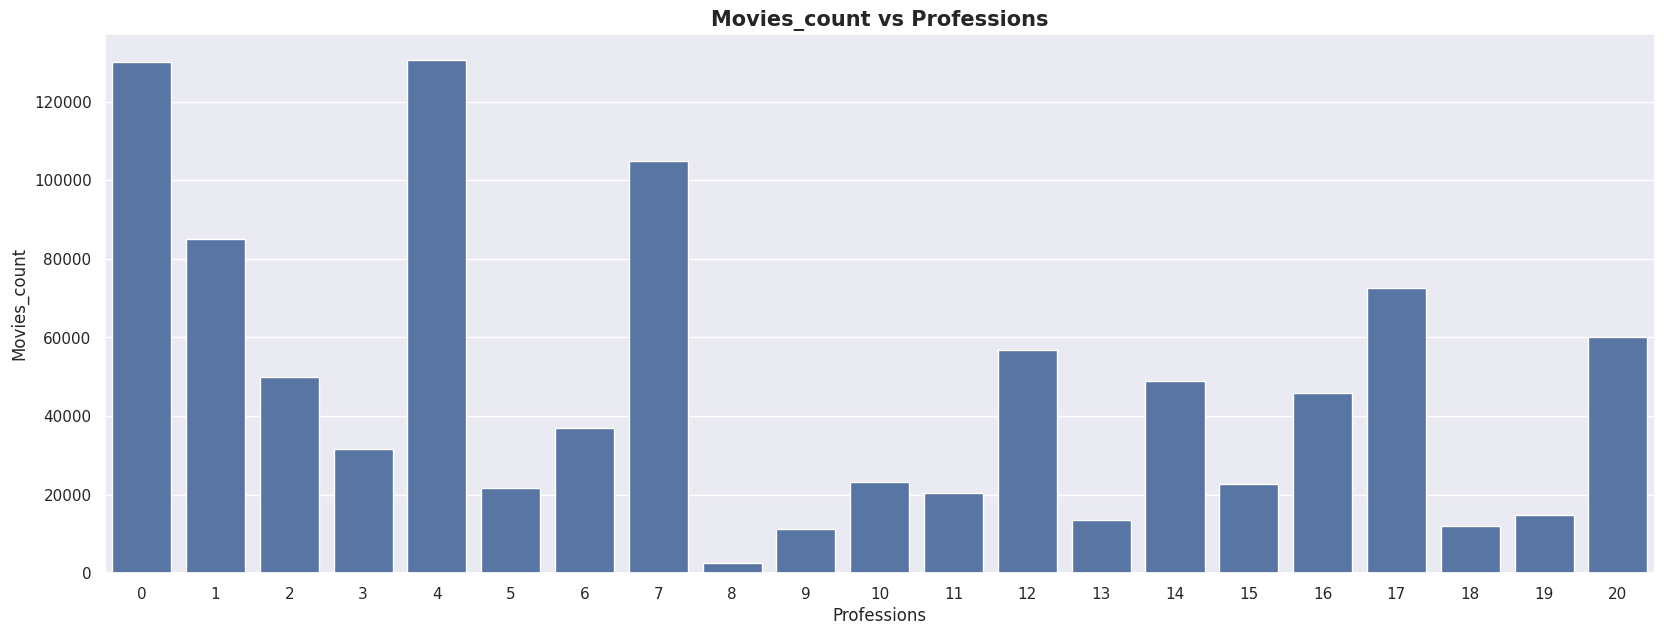

In [ ]:
plt.figure(figsize=(20,7))
x = data.occupation.value_counts().sort_index().index
y = data.occupation.value_counts().sort_index().values
sns.barplot(x=x, y=y)
plt.xlabel('Professions')
plt.ylabel('Movies_count')
plt.title('Movies_count vs Professions', fontsize = 15, fontweight = 'bold')
plt.show()

=> Users of profession **4: "college/grad student"** have watched and rated most number of movies followed by

**0: "other" or not specified**,

**7: "executive/managerial"** and

**1: "academic/educator"**.

--------------------------------

**3.	Most of the users in our dataset who’ve rated the movies are Male. (T/F)**

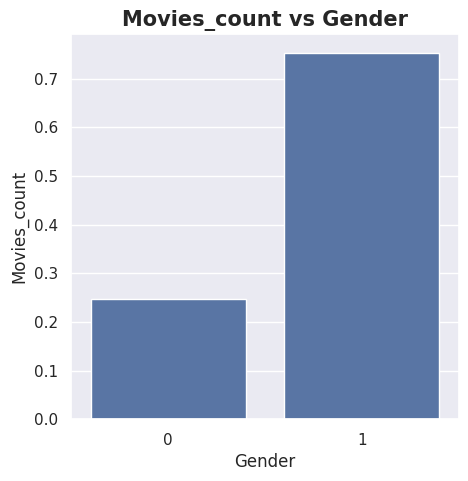

In [ ]:
plt.figure(figsize=(5,5))
x = data.gender.value_counts(normalize = True).sort_index().index
y = data.gender.value_counts(normalize = True).sort_index().values
sns.barplot(x=x, y=y)
plt.xlabel('Gender')
plt.ylabel('Movies_count')
plt.title('Movies_count vs Gender', fontsize = 15, fontweight = 'bold')
plt.show()

=> Out of all responses, **75% were given by "1: Male"**. Hence the statement is True.

Around 25% responses were received from **"0: Female"**

--------------------------------


**4.	Most of the movies present in our dataset were released in which decade?**

a.	70s

b. 90s

c. 50s

d.80s

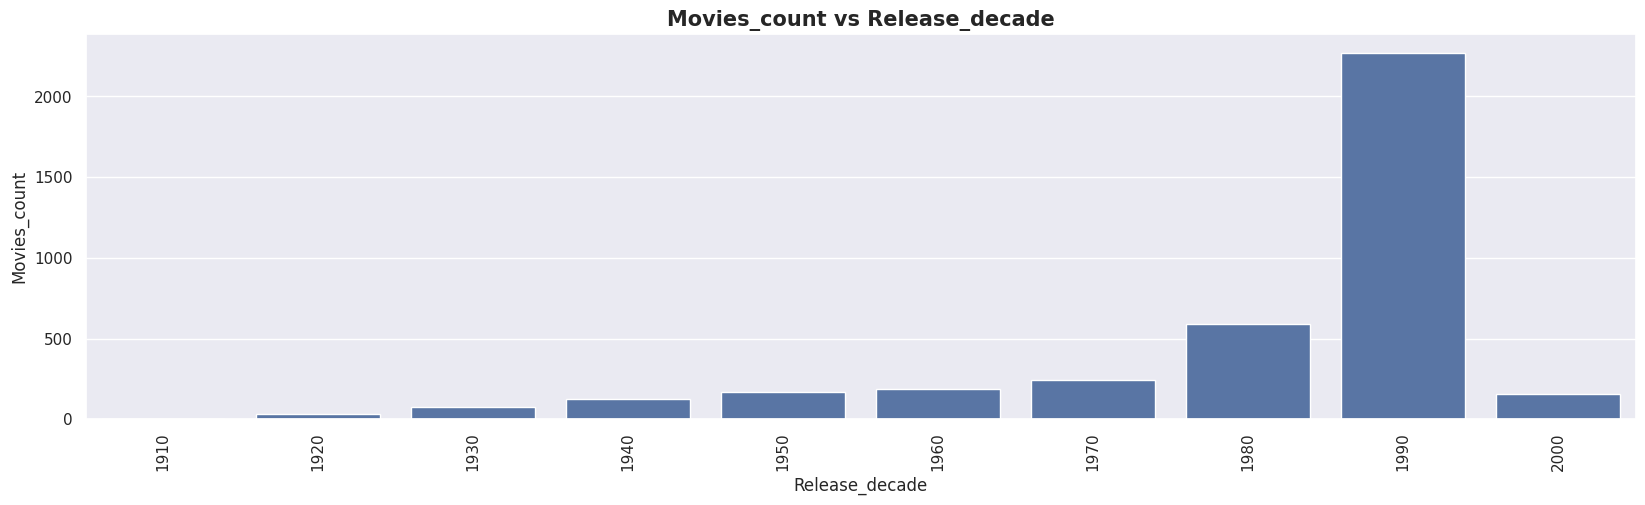

In [ ]:
x= movies.groupby((movies.release_year//10)*10)['movieID'].count().index
y = movies.groupby((movies.release_year//10)*10)['movieID'].count().values

plt.figure(figsize=(20,5))
sns.barplot(x=x, y=y)
plt.xticks(rotation=90)
plt.xlabel('Release_decade')
plt.ylabel('Movies_count')
plt.title('Movies_count vs Release_decade', fontsize = 15, fontweight = 'bold')
plt.show()

=> Most of the movies present in our dataset were released in **Decade 90s (1990)**

----------------------------

**5. The movie with maximum no. of ratings is**

In [ ]:
data_pivot_rating.head(5)

,count_rating,mean_rating
title,,
American Beauty (1999),3428,4.31739
Star Wars: Episode IV - A New Hope (1977),2991,4.45369
Star Wars: Episode V - The Empire Strikes Back (1980),2990,4.29298
Star Wars: Episode VI - Return of the Jedi (1983),2883,4.02289
Jurassic Park (1993),2672,3.76385


=> **American Beauty (1999)**. Tope 5 are shown above.

-----------------------------------



**6.	Name the top 3 movies similar to ‘Liar Liar’ on the item-based approach**

In [ ]:
movie = 'Liar Liar (1997)'
recommender_1(movie, movie_matrix, data_pivot_rating, n_reccomend = 3)
recommender_2(movie, movie_matrix, n_reccomend = 3)

----------------------------------------------------------------------------------------------------
Top 3 Recommended Movies to "Liar Liar (1997)" are as follow:
----------------------------------------------------------------------------------------------------
Mrs. Doubtfire (1993)
Dumb & Dumber (1994)
Ace Ventura: Pet Detective (1994)
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Top 3 Recommended Movies to "Liar Liar (1997)" are as follow:
----------------------------------------------------------------------------------------------------
Mrs. Doubtfire (1993)
Ace Ventura: Pet Detective (1994)
Dumb & Dumber (1994)
----------------------------------------------------------------------------------------------------


=> Movie similar to 'Liar-Liar' are shown above.

------------------------------------------------------


**7.	On the basis of approach, Collaborative Filtering methods can be classified into ___-based and ___-based.**

=> **User-based** (which measures the similarity between target users and other users)

&

**Item-based** (which measures the similarity between the items that target users rate or interact with and other items)


-----------------------------------------------

**8.	Pearson Correlation ranges between ____ & ____ whereas, Cosine Similarity belongs to the interval between ___ and ___ .**

=> Pearson Correlation ranges between **-1 to 1** whereas, Cosine Similarity belongs to the interval between **0 and 1**.

----------------------------------

**9.	Mention the RMSE and MAPE that you got while evaluating the Matrix Factorization model.**


=> Model Performance 3 Folds CV: **Mean RMSE = 0.9100** and **Mean MAE = 0.7209**

----------------------------------


**10.	Give the sparse ‘row’ matrix representation for the following dense matrix -**

[ [1 0]

[3 7] ]


=> **Array representation:**

rows  =   [0, 1, 1 ]

columns = [0, 0, 1 ]

values =  [1, 3, 7 ]



**Linked List representation:**

[row, column, value, pointer_to_next_node]


[0, 0, 1 ] ---> [1, 0,, 3 ] ---> [1, 1, 7 ] (null)   


-----------------------------------

## ------------------------------------------ END--------------------------------------------------